In [1]:
%pip install numpy pandas scikit-learn matplotlib shap lime

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/545.3 kB ? eta -:--:--
   ------------------- -------------------- 262.1/545.3 kB ? eta -:--:--
   ---------------------------------------- 545.3/545.3 kB 1.8 MB/s  0:00:00
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.9 MB 2.1 MB/s eta 0:00:06
   ---- ----------------------------------- 1.3/12.9 MB 2.3 MB/s eta 0:00:06
   ----- ---------------------------------- 1.8/12.9 MB 2.3 MB/s eta 0:00:05
   ------ --------------------------------- 2.1/12.9 MB 2.3 MB/s eta 0:00:05
   -------- ------------------------------- 2.6/12.9 MB 2.2 MB/s eta 0:00:05
   -------- ------------------------------- 2.9/12.9 MB 2.0 MB/s eta 0:00:06
   --------- ------------------------------ 3.1/12.9 MB 1.9 MB/s eta 0:00:0

  DEPRECATION: Building 'lime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'lime'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    roc_curve, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)

In [4]:
import shap
import warnings
warnings.filterwarnings("ignore")

E:\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
file_path = "bank-additional-full.csv"
df = pd.read_csv(file_path, sep=";")

In [7]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [14]:
(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [15]:
print("\nTarget distribution:")
print(df['y'].value_counts())


Target distribution:
y
no     36548
yes     4640
Name: count, dtype: int64


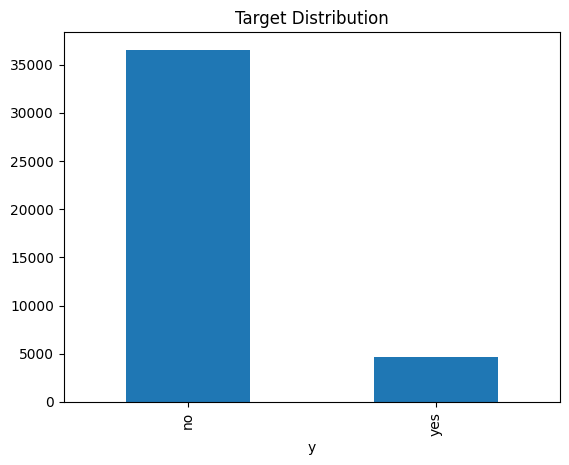

In [16]:
df['y'].value_counts().plot(kind="bar", title="Target Distribution")
plt.show()

**Preprocessing (for both models)**

In [18]:
# Encode target (yes=1, no=0)
y = df['y'].map({'yes': 1, 'no': 0})

In [19]:
# One-hot encode categorical features
X = pd.get_dummies(df.drop(columns=['y']), drop_first=True)

In [21]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [22]:
X_train.shape, X_test.shape

((32950, 53), (8238, 53))

**Logistic Regression Model**

In [23]:
# Training
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [24]:
#  Evaluation
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

In [26]:
print("Logistic Regression")
print(classification_report(y_test, y_pred_lr, digits=4))

Logistic Regression
              precision    recall  f1-score   support

           0     0.9285    0.9766    0.9519      7310
           1     0.6885    0.4073    0.5118       928

    accuracy                         0.9125      8238
   macro avg     0.8085    0.6920    0.7319      8238
weighted avg     0.9014    0.9125    0.9024      8238



**f1_score**

In [29]:
 f1_score(y_test, y_pred_lr)

0.5118483412322274

**ROC-AUC**

In [31]:
roc_auc_score(y_test, y_proba_lr)

np.float64(0.9394204915326195)

**Confusion Matrix**

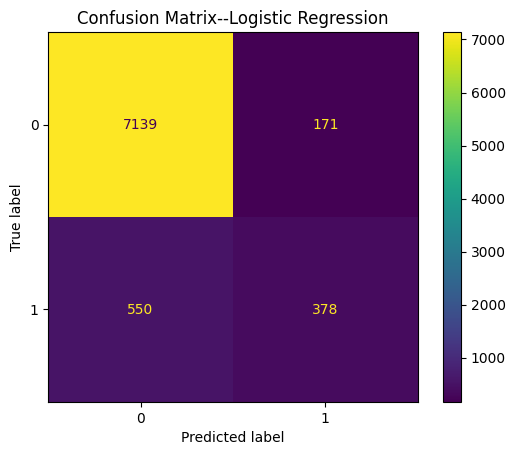

In [51]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title("Confusion Matrix-""-Logistic Regression")
plt.show()

**ROC Curve**

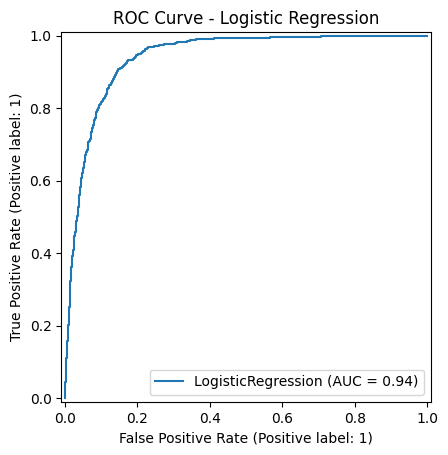

In [33]:
RocCurveDisplay.from_estimator(lr, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

**SHAP Explanation of Logistic Regression**

In [34]:
shap.initjs()
explainer_lr = shap.LinearExplainer(lr, X_train)

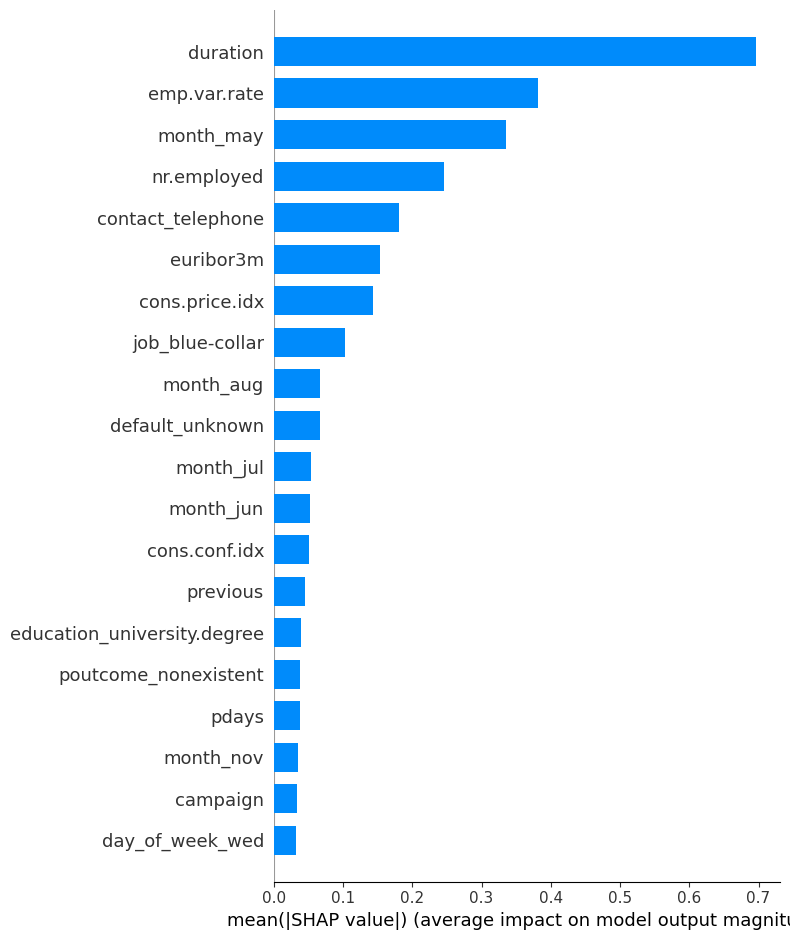

In [38]:
# Use small sample for speed
X_sample_lr = X_test.sample(5, random_state=42)
shap_values_lr = explainer_lr.shap_values(X_sample_lr)

shap.summary_plot(shap_values_lr, X_sample_lr, plot_type="bar")

**Random Forest Model**

In [40]:
# Training
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [41]:
# Evaluation
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

In [42]:
print("Random Forest")
print(classification_report(y_test, y_pred_rf, digits=4))

Random Forest
              precision    recall  f1-score   support

           0     0.9388    0.9702    0.9543      7310
           1     0.6813    0.5022    0.5782       928

    accuracy                         0.9175      8238
   macro avg     0.8101    0.7362    0.7662      8238
weighted avg     0.9098    0.9175    0.9119      8238



**F1-score**

In [45]:
f1_score(y_test, y_pred_rf)

0.5781637717121588

**ROC-AUC**

In [46]:
roc_auc_score(y_test, y_proba_rf)

np.float64(0.9491301181659512)

**Confusion Matrix**

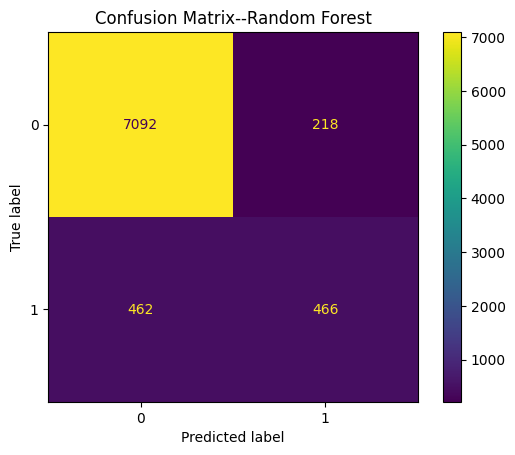

In [53]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title("Confusion Matrix-""-Random Forest")
plt.show()

**ROC Curve**

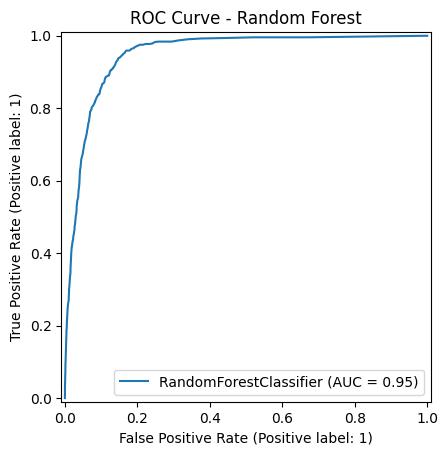

In [54]:
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

**SHAP Explanation of Random Forest**

In [62]:
explainer_rf = shap.TreeExplainer(rf)

In [64]:
# Use a smaller sample for speed
X_sample_rf = X_test.sample(100, random_state=42)

X_sample_rf shape: (100, 53)
shap_values_rf shape: (100, 53)

🔍 Explanation for instance 9


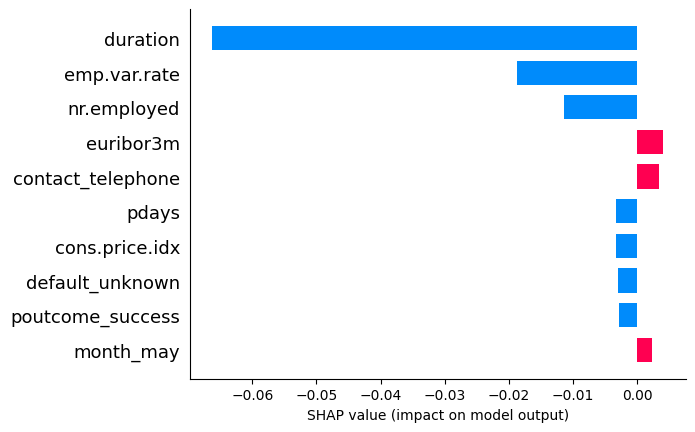


🔍 Explanation for instance 10


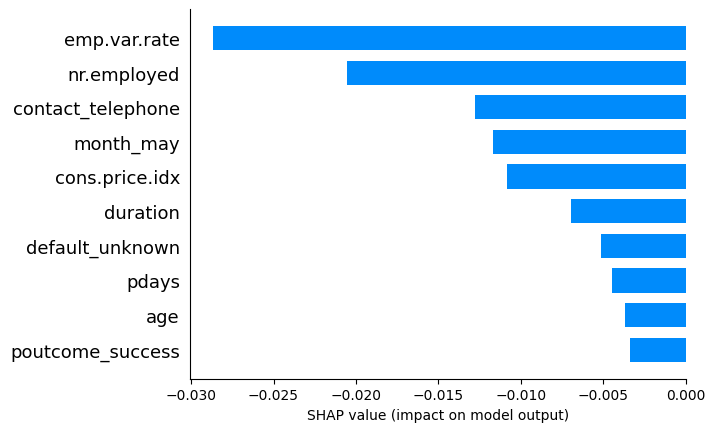


🔍 Explanation for instance 29


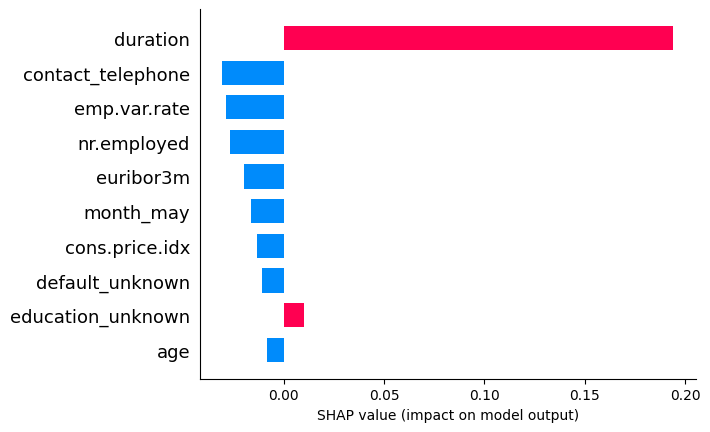


🔍 Explanation for instance 44


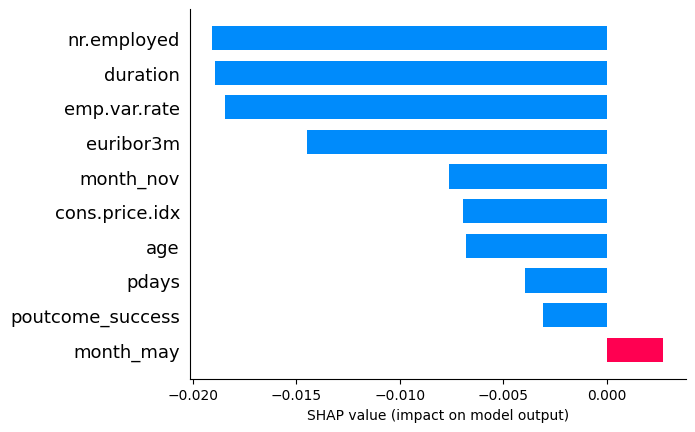


🔍 Explanation for instance 90


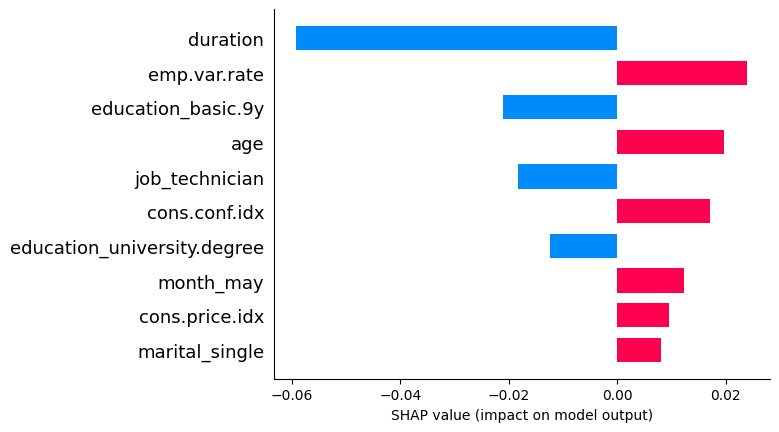

In [81]:
import numpy as np
import shap

# Get SHAP values
shap_values = explainer_rf.shap_values(X_sample_rf)

# Handle different output formats
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_rf = shap_values[1]              # positive class
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap_values_rf = shap_values[:, :, 1]        # pick class 1
else:
    shap_values_rf = shap_values                 # already correct shape

print("X_sample_rf shape:", X_sample_rf.shape)
print("shap_values_rf shape:", shap_values_rf.shape)

# Pick 5 random samples to explain
idx_positions = np.random.choice(X_sample_rf.shape[0], 5, replace=False)

for pos in idx_positions:
    print(f"\n🔍 Explanation for instance {pos}")
    row_shap = shap_values_rf[pos, :]   # 1D array of SHAP values for this row
    shap.bar_plot(
        row_shap,
        feature_names=X_sample_rf.columns,
        max_display=10
    )


**Comparison of both Models**
**Logistic Regression & Random Forest**

📊 Model Performance Comparison


,Model,Accuracy,F1-score,ROC-AUC
0,Logistic Regression,0.912479,0.511848,0.93942
1,Random Forest,0.917456,0.578164,0.94913


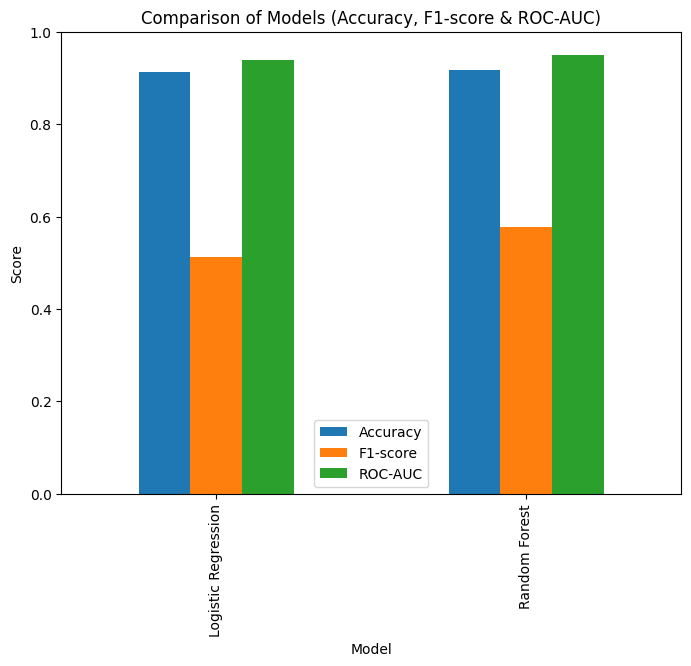

In [82]:
from sklearn.metrics import accuracy_score

# Collecting metrics
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_rf)
    ]
})

# Displaying nicely
print("📊 Model Performance Comparison")
display(results)

# Bar plot for quick visualization
results.set_index("Model")[["Accuracy", "F1-score", "ROC-AUC"]].plot(kind="bar", figsize=(8,6))
plt.title("Comparison of Models (Accuracy, F1-score & ROC-AUC)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()
